<a href="https://colab.research.google.com/github/Nishimura35/weatherwise-marina-nishimura/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# =====================================
# 1. Setup and Configuation
# =====================================
!pip install pyinputplus
!pip install fetch-my-weather
# !pip install hands-on-ai

import os
import re

from IPython.display import display, HTML
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip

import fetch_my_weather
# from hands_on_ai.chat import get_response


os.environ['HANDS_ON_AI_SERVER'] = 'https://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'

Hi I'm Weatherwise App!
I can help you check the weather forecast.

Which city are you interested in? (type 'exit' to quit)
Tokyo
How many days forecast? (1-3): 3
- Today: Partly cloudy, High: 20°C, Low: 19°C, Precipitation: 0.0 mm

- Tomorrow: Light rain shower, High: 20°C, Low: 17°C, Precipitation: 1.1 mm

- Day after tomorrow: Light rain shower, High: 18°C, Low: 16°C, Precipitation: 0.3 mm



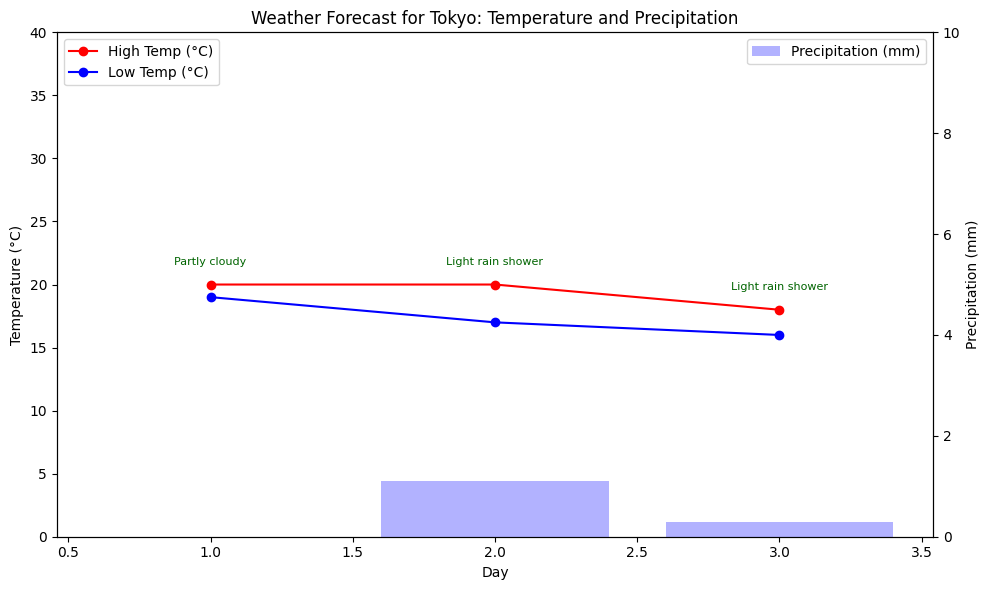


Clothing Advice:

AI Clothing Advice:
Today in Tokyo: Expect partly cloudy skies with a high of 20 degrees and a low of 19 degrees. There is no precipitation expected today.

Tomorrow in Tokyo: Brace for light rain showers, with temperatures dropping slightly - the high will be 20 degrees and the low around 17 degrees. About 1.1 mm of rainfall is forecasted.

The day after tomorrow in Tokyo: Be prepared for more light rain showers. Temperatures will further decrease to a high of 18 degrees and a low of 16 degrees, with roughly 0.3 mm of precipitation expected.

Would you like to check another city? (yes/no): 
n
Goodbye! Have a nice day!


In [42]:
# =====================================
# 2. Weather Data Functions
# =====================================
# Get weather data
def get_weather_data(location: str, forecast_days: int = 3, units='m') -> dict:
  try:
    if forecast_days < 1 or forecast_days > 5:
      return {"error": "forecast_days must be between 1 and 5"}

    response = fetch_my_weather.get_weather(
      location=location,
      units=units,
      view_options=str(forecast_days)
    )

    forecast = []
    raw_text = str(response)
    condition_pattern = r"weatherDesc=\[WeatherDesc\(value='([^']+)'\)\]"
    conditions = re.findall(condition_pattern, raw_text)

    max_temps = re.findall(r"maxtempC='(\d+)'", raw_text)
    min_temps = re.findall(r"mintempC='(\d+)'", raw_text)
    precips = re.findall(r"precipMM='([\d.]+)'", raw_text)

    for i in range(forecast_days):
      if i < len(max_temps) and i < len(min_temps) and i < len(precips):
        high = int(max_temps[i])
        low = int(min_temps[i])
        rain = float(precips[i])
        condition = conditions[i] if i < len(conditions) else "Unknown"

        forecast.append({
          "day": i + 1,
          "condition": condition,
          "high_temp": high,
          "low_temp": low,
          "precipitation_mm": float(rain)
        })

    return {
      "location": location,
      "forecast_days": len(forecast),
      "forecast": forecast
    }

  # Connection error
  except ConnectionError:
    print("Network error. Please check your connection and try again.")
    return None

  # Value error
  except ValueError as ve:
    print(f"Invalid input value: {ve}")
    return None

  # Unexpected error
  except Exception as e:
    print(f"An unexpected error occurred: {e}")
    return None

def get_day_label(day_number):
    if day_number == 1:
        return "Today"
    elif day_number == 2:
        return "Tomorrow"
    elif day_number == 3:
        return "Day after tomorrow"
    else:
        return f"Day {day_number}"

# =====================================
# 3. Preprocess Functions
# =====================================
# Preprocess the forecast
'''
def preprocess_forecast_data(raw_data):
  processed = []
  for entry in raw_data:
    high = int(entry['high_temp'].replace("°C", "").replace("+", ""))
    low = int(entry['low_temp'].replace("°C", "").replace("+", ""))
    processed.append({
      "day": entry['day'],
      "condition": entry.get('condition', "Unknown"),
      "high_temp": high,
      "low_temp": low,
      "precipitation_mm": entry['precipitation_mm']
    })
  return processed
'''

# =====================================
# 4. Visualisation Functions
# =====================================
# Show the weather forecast
def create_visualisation(forecast, location, output_type='display'):
  days = [entry['day'] for entry in forecast]
  high_temps = [entry['high_temp'] for entry in forecast]
  low_temps = [entry['low_temp'] for entry in forecast]
  precipitation = [entry['precipitation_mm'] for entry in forecast]

  fig, ax1 = plt.subplots(figsize=(10, 6))

  # Plot temperature lines on left y-axis
  ax1.plot(days, high_temps, color='red', marker='o', label='High Temp (°C)')
  ax1.plot(days, low_temps, color='blue', marker='o', label='Low Temp (°C)')
  ax1.set_xlabel('Day')
  ax1.set_ylabel('Temperature (°C)')
  ax1.legend(loc='upper left')
  ax1.set_ylim(0, 40)

  # Create second y-axis for precipitation bars
  ax2 = ax1.twinx()
  ax2.bar(days, precipitation, alpha=0.3, color='blue', label='Precipitation (mm)')
  ax2.set_ylabel('Precipitation (mm)')
  ax2.legend(loc='upper right')
  ax2.set_ylim(0, 10)

  for i, condition in enumerate([entry.get('condition', '') for entry in forecast]):
    ax1.annotate(
      condition,
      (days[i], high_temps[i] + 1),
      textcoords="offset points",
      xytext=(0, 5),
      ha='center',
      fontsize=8,
      color='darkgreen'
    )

  plt.title(f'Weather Forecast for {location}: Temperature and Precipitation')
  plt.tight_layout()
  safe_location = re.sub(r'\W+', '_', location)

  if output_type == 'figure':
    return fig
  elif output_type == 'save':
    plt.savefig(f"{forecast[0]['day']}_{safe_location}_forecast.png")
    print("Graph saved!")
    plt.close(fig)
  else:
    plt.show()
    plt.close(fig)

def display_forecast(weather_data, days):
    print(f"Weather forecast for {weather_data.nearest_area[0].areaName[0].value}:\n")

    for day in weather_data.weather[:days]:
        date = day.date
        desc = day.hourly[4].weatherDesc[0].value.strip()
        max_temps = day.maxtempC
        min_temps = day.mintempC
        print(f"{date}: {desc}, Max: {max_temps}°C, Min: {min_temps}°C")


# Natural Language Processing
def create_clothing_prompt_en(forecast):
    prompt = "Here is the weather forecast. Based on this information, please provide clothing advice in English.\n\n"
    for day in forecast:
        prompt += (f"Day {day['day']}: Weather: {day['condition']}, "
                   f"High: {day['high_temp']}°C, Low: {day['low_temp']}°C, "
                   f"Precipitation: {day['precipitation_mm']}mm\n")
    prompt += "\nClothing Advice:"
    return prompt

def get_ai_advice(prompt):
    try:
        response = requests.post(
            os.environ['HANDS_ON_AI_SERVER'] + "/v1/chat/completions",
            json={
                "model": os.environ['HANDS_ON_AI_MODEL'],
                "messages": [{"role": "user", "content": prompt}]
            },
            timeout=10
        )
        if response.status_code == 200:
            result = response.json()
            return result["choices"][0]["message"]["content"]
        else:
            return "Failed to get a response from the AI."
    except Exception as e:
        return f"Connection error to AI server: {e}"


# =====================================
# 5. Main function
# =====================================
display(HTML('''
  <style>
  body {
    background-color: #f0f8ff !important;
  }
  </style>
  <div style="background-color: #f0f8ff; padding: 10px; border-radius: 10px;">
      <h2 style="color: #2e8b57;">🌤️ Weatherwise App</h2>
      <p style="font-size: 16px;">Get your outfit advice with style!</p>
  </div>
'''))

def main():
  print("Hi I'm Weatherwise App!")
  print("I can help you check the weather forecast.\n")

  while True:
    try:
      location = input("Which city are you interested in? (type 'exit' to quit)\n")
      if location.lower() == 'exit':
        print("Goodbye! Have a nice day!")
        break

      if not location:
        print("Please enter a city name.")
        continue

      forecast_days = pyip.inputInt(prompt="How many days forecast? (1-3): ", min=1, max=3)
      weather_data = get_weather_data(
        location=location,
        forecast_days=forecast_days,
        units='m'
      )

      if not weather_data:
        print("Oops! No weather data returned.")
      elif "error" in weather_data:
        print(f"Oops! Something went wrong: {weather_data['error']}")
      elif not weather_data.get("forecast"):
        print("Oops! No forecast data received. Please try a different location or day range.")
      else:
        for day in weather_data["forecast"]:
          day_label = get_day_label(day['day'])
          print(f"- {day_label}: {day['condition']}, High: {day['high_temp']}°C, "
          f"Low: {day['low_temp']}°C, Precipitation: {day['precipitation_mm']} mm\n")

        create_visualisation(weather_data["forecast"], location)
        prompt_en = create_clothing_prompt_en(weather_data["forecast"])
        advice_en = get_ai_advice(prompt_en)
        print("\nClothing Advice:")
        prompt = f"""
        Please answer the weather advice using 'Today', 'Tomorrow', and 'Day after tomorrow' instead of 'Day 1', 'Day 2', etc.
        Here is the weather data: {weather_data}
        """
        advice = get_ai_advice(prompt)
        print("\nAI Clothing Advice:")
        print(advice)


      again = input("\nWould you like to check another city? (yes/no): \n").strip().lower()
      if again not in ['yes', 'y']:
        print("Goodbye! Have a nice day!")
        break

    except ConnectionError:
      print("It looks like there's a problem with your internet connection. Please check and try again.")
    except Exception as e:
      print(f"Oops! Something went wrong: {e}")
      print("Please try again or contact support if the issue persists.")


# =====================================
# 6. Main Script
# =====================================
if __name__ == '__main__':
    main()

# Testing and Examples
# Include sample input/output for each function